In [219]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from google.cloud import bigquery
import datetime as dt
import geopandas
import folium
import Levenshtein
import random

In [255]:
from scipy.cluster.hierarchy import single, complete, average, ward, dendrogram
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sktime.distances import dtw_distance
from tslearn.barycenters import dtw_barycenter_averaging
from scipy.cluster.hierarchy import fcluster

In [49]:
def get_df_from_bq(project_name, query):
    """
    configurar primeiro a CLI do google cloud 
    """
    client = bigquery.Client(project=project_name)
    query_job = client.query(query)
    df = query_job.result().to_dataframe()

    return df

In [50]:
query = "SELECT * FROM `windproject-393609.FAOSTAT.crop_yield`"
project_name = "windproject-393609"
df = get_df_from_bq(project_name, query)

In [7]:
df.head()

,Domain_Code,Domain,Area_Code__M49_,Area,Element_Code,Element,Item_Code__CPC_,Item,Year_Code,Year,Unit,Value,Flag,Flag_Description
0,QCL,Crops and livestock products,4,Afghanistan,5419,Yield,1312,Bananas,1961,1961,,NaN,,
1,QCL,Crops and livestock products,4,Afghanistan,5419,Yield,1312,Bananas,1962,1962,,NaN,,
2,QCL,Crops and livestock products,4,Afghanistan,5419,Yield,1312,Bananas,1963,1963,,NaN,,
3,QCL,Crops and livestock products,4,Afghanistan,5419,Yield,1312,Bananas,1964,1964,,NaN,,
4,QCL,Crops and livestock products,4,Afghanistan,5419,Yield,1312,Bananas,1965,1965,,NaN,,


In [51]:
df.drop(columns = ["Domain","Domain_Code","Area_Code__M49_","Element_Code","Item_Code__CPC_","Year_Code"], inplace = True)

In [52]:
df.shape

(115839, 8)

In [11]:
df.Domain.value_counts()

Domain
Crops and livestock products    115839
Name: count, dtype: int64

In [12]:
df.Area.value_counts()

Area
Afghanistan       549
Yugoslav SFR      549
Sri Lanka         549
Sudan             549
Sudan (former)    549
                 ... 
Kuwait            549
Kyrgyzstan        549
Latvia            549
Lebanon           549
Zimbabwe          549
Name: count, Length: 211, dtype: int64

In [13]:
df.Element.value_counts()

Element
Yield             38613
Production        38613
Area harvested    38613
Name: count, dtype: int64

In [14]:
df.Item.value_counts()

Item
Bananas     38613
Rice        38613
Potatoes    38613
Name: count, dtype: int64

In [16]:
df.Year.value_counts()

Year
1961    1899
1992    1899
1994    1899
1995    1899
1996    1899
        ... 
1986    1899
1987    1899
1988    1899
1989    1899
2021    1899
Name: count, Length: 61, dtype: Int64

In [18]:
df.Unit.value_counts()

Unit
            46387
t           23491
ha          23418
100 g/ha    22543
Name: count, dtype: int64

In [20]:
df.Value.describe()

count    6.945200e+04
mean     1.172701e+06
std      8.939387e+06
min      0.000000e+00
25%      1.000000e+04
50%      5.330500e+04
75%      2.000000e+05
max      2.144299e+08
Name: Value, dtype: float64

### Let's check completeness of the data
- 1) regarding the rice crops

In [57]:
df["Value"] = df["Value"].fillna(value = np.nan)

In [61]:
df["Value"].info()

<class 'pandas.core.series.Series'>
RangeIndex: 115839 entries, 0 to 115838
Series name: Value
Non-Null Count  Dtype  
--------------  -----  
69452 non-null  float64
dtypes: float64(1)
memory usage: 905.1 KB


In [82]:
df["is_filled"] = df["Value"].apply(lambda x: 1 if not pd.isna(x) else 0)

In [96]:
df_rice = df[df.Item == "Rice"]

In [100]:
### keep only countries with at least 80% of the data

df_country = df_rice.groupby("Area").agg({"is_filled":"mean"})*100
df_country_new = df_country[df_country.is_filled >= 80]

In [101]:
len(df_country_new)

108

In [107]:
country_geopandas = geopandas.read_file(
    geopandas.datasets.get_path('naturalearth_lowres')
)

In [109]:
df_country_new

,is_filled
Area,
Afghanistan,100.000000
Albania,84.699454
Algeria,100.000000
Angola,100.000000
Argentina,100.000000
...,...
Uruguay,100.000000
Venezuela (Bolivarian Republic of),100.000000
Viet Nam,100.000000


In [119]:
df_country_new.reset_index(inplace = True)

In [122]:
match = df_country_new.merge(country_geopandas_names, how = "left", left_on = "Area", right_on="name")

In [124]:
match.name.isna().sum()

21

In [130]:
### lets use the levenstein distance to get best matches of these 21 countries
dict_matches = dict()
for name in list(match[match.name.isna()].Area.values):
    dict_matches[name] = dict()
    for geo_name in list(country_geopandas_names.name.values):
        dict_matches[name][geo_name] = Levenshtein.distance(name, geo_name)
        

In [141]:
for name in list(match[match.name.isna()].Area.values):
    bm = min(dict_matches[name], key=dict_matches[name].get)
    print(f"{name} best match is: {bm}")

Bolivia (Plurinational State of) best match is: Burkina Faso
Brunei Darussalam best match is: Belarus
Central African Republic best match is: Central African Rep.
China, Hong Kong SAR best match is: Dem. Rep. Congo
China, Taiwan Province of best match is: Papua New Guinea
China, mainland best match is: Thailand
Comoros best match is: Cameroon
Democratic People's Republic of Korea best match is: Dem. Rep. Congo
Democratic Republic of the Congo best match is: Dem. Rep. Congo
Dominican Republic best match is: Dominican Rep.
Eswatini best match is: eSwatini
Iran (Islamic Republic of) best match is: Dem. Rep. Congo
Lao People's Democratic Republic best match is: Central African Rep.
Republic of Korea best match is: South Korea
Solomon Islands best match is: Solomon Is.
Sudan (former) best match is: Sudan
Syrian Arab Republic best match is: Dominican Rep.
Türkiye best match is: Turkey
United Republic of Tanzania best match is: United States of America
Venezuela (Bolivarian Republic of) best 

### correct matches (9/21):

- Central African Republic best match is: Central African Rep.
- Democratic Republic of the Congo best match is: Dem. Rep. Congo
- Dominican Republic best match is: Dominican Rep.
- Eswatini best match is: eSwatini
- Republic of Korea best match is: South Korea
- Solomon Islands best match is: Solomon Is.
- Sudan (former) best match is: Sudan
- Türkiye best match is: Turkey
- Viet Nam best match is: Vietnam

In [143]:
df_country_new["Area"].replace({"Central African Republic":"Central African Rep.",
                               "Democratic Republic of the Congo":"Dem. Rep. Congo",
                               "Dominican Republic":"Dominican Rep.",
                               "Eswatini":"eSwatini",
                               "Republic of Korea":"South Korea",
                               "Solomon Islands":"Solomon Is",
                               "Sudan (former)":"Sudan",
                               "Türkiye":"Turkey",
                               "Viet Nam":"Vietnam"}, inplace = True)

<ipython-input-143-1d8777eb21cb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_country_new["Area"].replace({"Central African Republic":"Central African Rep.",


In [148]:
match_2 = df_country_new.merge(country_geopandas[["name", "iso_a3", "continent", "geometry"]], how = "left", left_on = "Area", right_on="name")

In [182]:
country_geopandas

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."
...,...,...,...,...,...,...
172,7111024,Europe,Serbia,SRB,101800.0,"POLYGON ((18.82982 45.90887, 18.82984 45.90888..."
173,642550,Europe,Montenegro,MNE,10610.0,"POLYGON ((20.07070 42.58863, 19.80161 42.50009..."
174,1895250,Europe,Kosovo,-99,18490.0,"POLYGON ((20.59025 41.85541, 20.52295 42.21787..."
175,1218208,North America,Trinidad and Tobago,TTO,43570.0,"POLYGON ((-61.68000 10.76000, -61.10500 10.890..."


In [155]:
df_rice_mean = df_rice.groupby("Area").agg({"Value":"mean"})

In [158]:
match_all = match_2.drop(columns = "name").merge(df_rice_mean.reset_index(), how = "left", left_on = "Area", right_on = "Area")

In [168]:
match_all = match_all.dropna()

In [175]:
match_all.geometry.isna().sum()

0

In [190]:
urban_area_map = folium.Map()
folium.Choropleth(
    geo_data=country_geopandas,
    name='choropleth',
    data=country_geopandas,
    columns=['name', 'pop_est'],
    key_on='feature.properties.pop_est',
    fill_color='Greens',
    nan_fill_color='Grey',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Percentage of population living in Urban areas'
).add_to(urban_area_map)
urban_area_map.save(f'urban_population.html')

In [189]:
os.getcwd()

'/Users/luisazevedo/Desktop/projects/the-wind-project/code'

In [154]:
df_rice_mean = df_rice.groupby("Area").agg({"Value":"mean"})

Value    62
dtype: int64

In [157]:
df_rice_mean.reset_index()

,Area,Value
0,Afghanistan,2.017134e+05
1,Albania,9.615135e+03
2,Algeria,8.229892e+03
3,Angola,1.350032e+04
4,Antigua and Barbuda,NaN
...,...,...
206,Viet Nam,1.010959e+07
207,Yemen,NaN
208,Yugoslav SFR,2.735320e+04
209,Zambia,1.336558e+04


#### Time series of rice crop yield

In [205]:
df_rice_yield.Year.min()

1961

In [206]:
df_rice_yield.Year.max()

2021

In [196]:
df_rice_yield = df_rice[df_rice.Element == 'Yield']

In [198]:
df_country = df_rice_yield.groupby("Area").agg({"is_filled":"mean"})*100
df_country_new = df_country[df_country.is_filled >= 90]

In [199]:
len(df_country_new)

## 100 countries have at least 90% of the values filled for yield

100

In [215]:
### let's check the yields missing

list_missing = list(df_country_new[df_country_new.is_filled != 100].index)
list_filled = list(df_country_new[df_country_new.is_filled == 100].index)

In [216]:
df_missing = df_rice_yield[df_rice_yield.Area.isin(list_missing)]

In [217]:
df_filled = df_rice_yield[df_rice_yield.Area.isin(list_filled)]

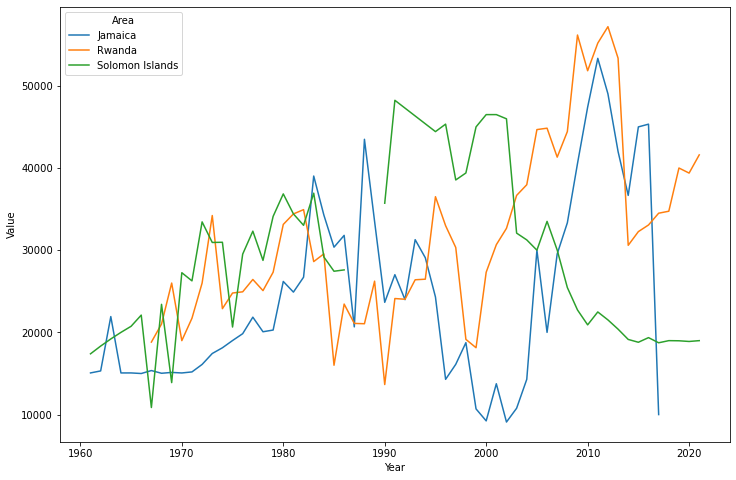

In [288]:
plt.figure(figsize=(12,8))
sns.lineplot(data = df_missing, x = "Year", y = "Value", hue = "Area")
plt.show()

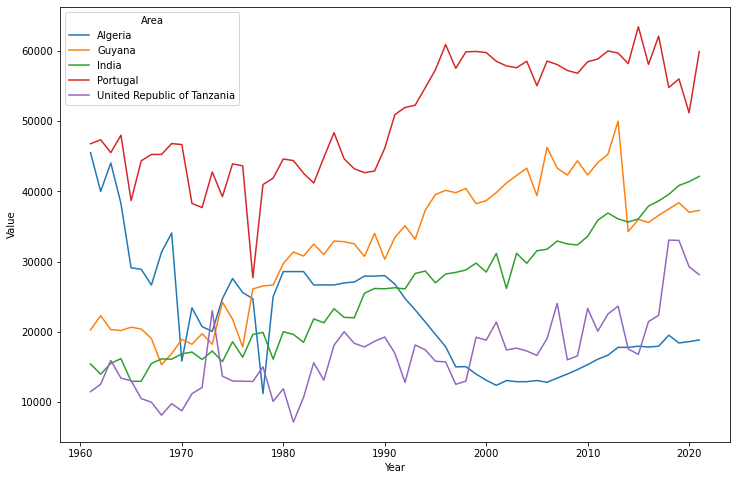

In [292]:
plt.figure(figsize=(12,8))
sns.lineplot(data = df_filled[df_filled.Area.isin(random.choices(list(df_filled.Area.values), k = 5))], x = "Year", y = "Value", hue = "Area")
plt.show()

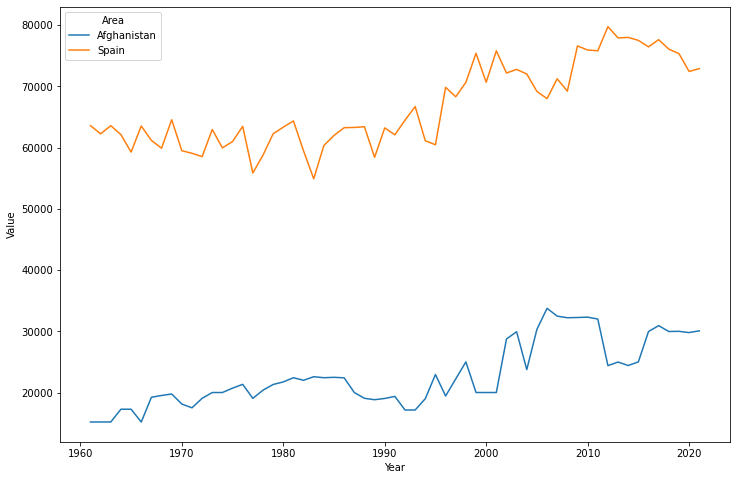

In [274]:
plt.figure(figsize=(12,8))
sns.lineplot(data = df_filled[df_filled.Area.isin(['Afghanistan','Spain'])], x = "Year", y = "Value", hue = "Area")
plt.show()

In [297]:
df_filled[df_filled.Area.isin(['Afghanistan'])].sort_values(by = "Year")

,Area,Element,Item,Year,Unit,Value,Flag,Flag_Description,is_filled
24186,Afghanistan,Yield,Rice,1961,100 g/ha,15190.0,E,Estimated value,1
24187,Afghanistan,Yield,Rice,1962,100 g/ha,15190.0,E,Estimated value,1
24188,Afghanistan,Yield,Rice,1963,100 g/ha,15190.0,E,Estimated value,1
24189,Afghanistan,Yield,Rice,1964,100 g/ha,17273.0,E,Estimated value,1
24190,Afghanistan,Yield,Rice,1965,100 g/ha,17273.0,E,Estimated value,1
...,...,...,...,...,...,...,...,...,...
16115,Afghanistan,Yield,Rice,2017,100 g/ha,30919.0,A,Official figure,1
16116,Afghanistan,Yield,Rice,2018,100 g/ha,29963.0,A,Official figure,1
16117,Afghanistan,Yield,Rice,2019,100 g/ha,29993.0,A,Official figure,1
16118,Afghanistan,Yield,Rice,2020,100 g/ha,29789.0,A,Official figure,1


In [299]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
def minmax_ts_transform(df_multi):
    
    df_multi.sort_values(by = ["Area","Year"], ascending = [True,True], inplace = True)
    areas = list(df_multi.Area.unique())
    scaled_series = []
    dict_scaled = dict()
    i = 0
    scaler = MinMaxScaler()
    temp = df_multi[['Value']]
    mmax = scaler.fit(df_multi[['Value']])

    for area in areas:

        temp2 = df_multi[df_multi.Area == area][['Value']]
        temp3 = mmax.transform(temp2)
        scaled_series.append(temp3.reshape(len(temp2)))
        dict_scaled[area] = scaled_series[i]
        i += 1
        
    return dict_scaled

In [300]:
scaled_rice = minmax_ts_transform(df_filled)

<ipython-input-299-631789a4b010>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_multi.sort_values(by = ["Area","Year"], ascending = [True,True], inplace = True)


In [301]:
scaled_rice

{'Afghanistan': array([0.11801538, 0.11801538, 0.11801538, 0.13670084, 0.13670084,
        0.11792567, 0.15419324, 0.15681262, 0.15898347, 0.14428985,
        0.13873714, 0.15262341, 0.16116329, 0.16116329, 0.1675682 ,
        0.17312091, 0.15262341, 0.16458103, 0.17292356, 0.17666424,
        0.18281798, 0.17905039, 0.18431605, 0.18283592, 0.18342797,
        0.18269239, 0.16116329, 0.15269517, 0.15061403, 0.15245297,
        0.15545808, 0.13553468, 0.13553468, 0.15219283, 0.18754541,
        0.15604116, 0.18109565, 0.20601559, 0.16116329, 0.16116329,
        0.16116329, 0.23957408, 0.25024893, 0.19474869, 0.25367565,
        0.28450712, 0.2730339 , 0.27070158, 0.27105143, 0.27157171,
        0.26880881, 0.20054361, 0.20583618, 0.20071405, 0.20601559,
        0.25053599, 0.25911175, 0.25053599, 0.2508051 , 0.24897512,
        0.25150479]),
 'Algeria': array([0.39001767, 0.34057249, 0.37682212, 0.32509845, 0.24283933,
        0.24105421, 0.2208617 , 0.26282552, 0.28734178, 0.12357706,


In [303]:
def interp_ts(df_multi, dict_scaled):
    
    time_interpol = {k: np.interp(np.linspace(0, 1, df_multi.Area.value_counts().max()), 
                               np.linspace(0, 1, len(dict_scaled[k])), data) 
                  for k, data in (dict_scaled.items())}
    return time_interpol

In [304]:
ts = interp_ts(df_filled, scaled_rice)

<AxesSubplot:>

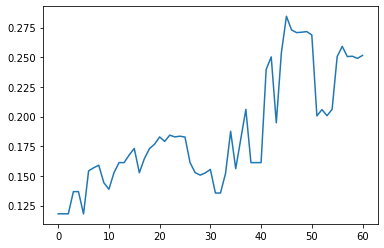

In [306]:
pd.Series(ts['Afghanistan']).plot()

In [307]:
def calc_dtw_matrix(ts_data: list):
    
    for i in range(len(ts_data)):
        l = len(ts_data[i])
        ts_data[i] = ts_data[i].reshape((l, 1))

    n_series = len(ts_data)
    distance_matrix = np.zeros(shape=(n_series, n_series))

    # Build distance matrix
    for i in range(n_series):
        for j in range(n_series):
            x = ts_data[i]
            y = ts_data[j]
            if i != j:
                dist = dtw_distance(x, y)
                distance_matrix[i, j] = dist
                
    return distance_matrix

In [308]:
full_areas = list(df_filled.Area.unique())
ts_all = [ts[area] for area in full_areas]

In [309]:
dtw = calc_dtw_matrix(ts_all)

In [310]:
def hierar_cluster(dist_mat, method='complete'):
    
    if method == 'complete':
        Z = complete(dist_mat)
    if method == 'single':
        Z = single(dist_mat)
    if method == 'average':
        Z = average(dist_mat)
    if method == 'ward':
        Z = ward(dist_mat)
    
    fig = plt.figure(figsize=(16, 8))
    dn = dendrogram(Z)
    plt.title(f"Dendrogram for {method}-linkage with correlation distance")
    plt.show()
    
    return Z

def visualize_clusters(cluster_count, list_labels, data):
    
    plot_count = math.ceil(math.sqrt(cluster_count))

    fig, axs = plt.subplots(plot_count,plot_count,figsize=(30,30))
    fig.suptitle('Clusters')
    row_i=0
    column_j=0
    barys = []
    avgs = []

    k = 0
    for label in set(list_labels):
        cluster = []
        for i in range(len(list_labels)):
                if(list_labels[i]==label):
                    axs[row_i, column_j].plot(data[i],c="gray",alpha=0.5)
                    cluster.append(data[i])
        barys.append(dtw_barycenter_averaging(cluster))
        avgs.append(np.average(cluster,axis=0))
        #axs[row_i, column_j].plot(barys[k],color="red", alpha = 0.4)
        axs[row_i, column_j].plot(avgs[k],color="red", alpha = 1, label = "avg time-series")
        #axs[row_i, column_j].plot(np.average(np.average(np.vstack(cluster),axis=1), axis=1),color="orange")
        axs[row_i, column_j].set_title("Cluster "+str(label))
        axs[row_i, column_j].set_xlabel("Time index")
        axs[row_i, column_j].set_ylabel("scaled TicketCloseRate")
        axs[row_i, column_j].set_yticks(np.arange(0, 1, step=0.1))
        axs[row_i, column_j].legend()
        column_j+=1
        k +=1
        if column_j%plot_count == 0:
            row_i+=1
            column_j=0

    plt.show()
    
    return barys, avgs

/Users/luisazevedo/opt/anaconda3/lib/python3.8/site-packages/scipy/cluster/hierarchy.py:834: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


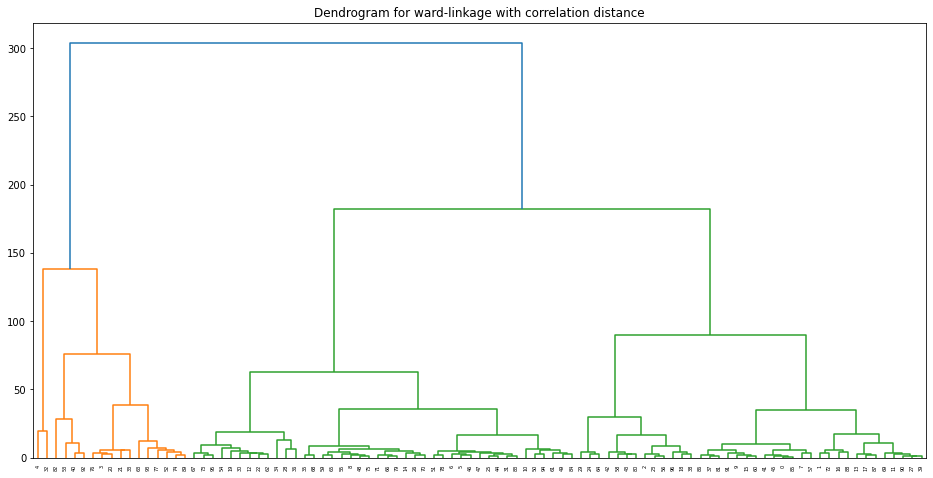

In [311]:
link_matrix = hierar_cluster(dtw, method='ward')

In [312]:
labels = fcluster(link_matrix, 6, criterion='maxclust')

In [267]:
import math

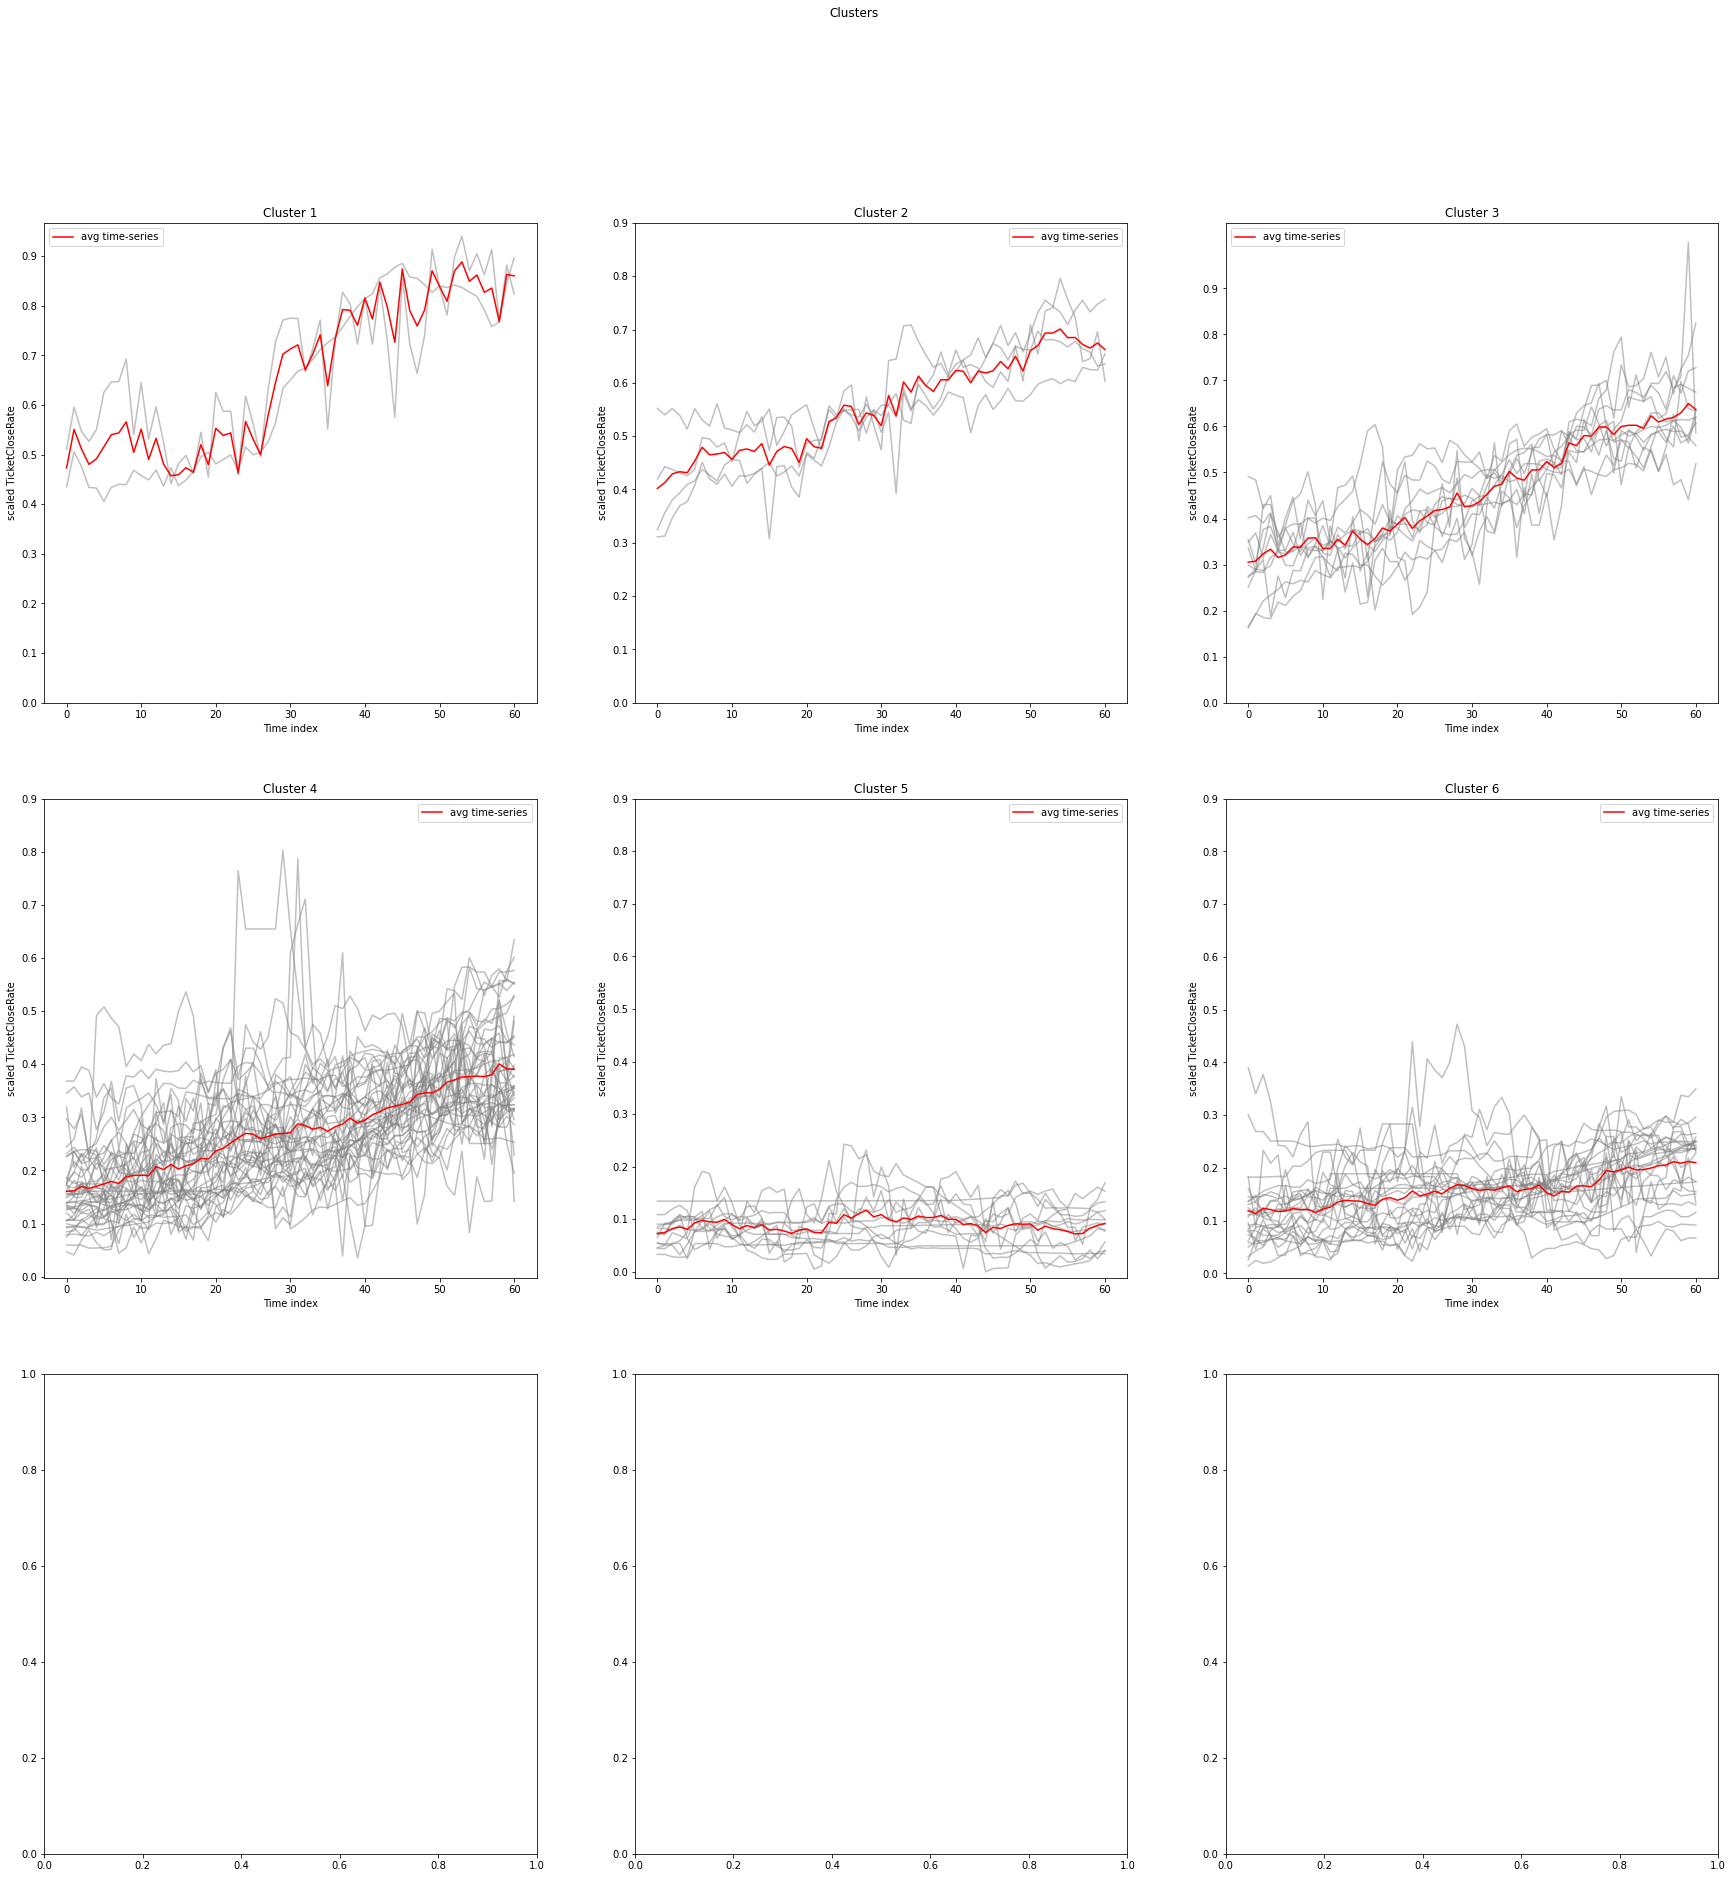

In [313]:
b, a = visualize_clusters(6, labels, ts_all)